In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
np.random.seed(42069)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score

ModuleNotFoundError: No module named 'keras'

### Objetivo: A partir de las siguientes variables:
### Edad, sexo, vitamina D, hormona paratiroidea, circunferencia de la cintura, indice de masa corporal, altura, raza (blanco, negro o mexicano), ingreso familiar anual, calcio, fósforo y energía en calorías...

# Hacer un clasificador ¡De estado civil!

### Las diferentes clases a encontrar son: 

1. Casado 
2. Viudo
3. Divorciado
4. Separado 
5. Nunca se ha casado
6. En unión libre (Goals)

In [2]:
df = pd.read_csv('BaseDatosEstudio.csv')
datos = df.loc[:,['ridagemn', 'ridreth1', 'indhhinc', 'indfminc', 'indfmpir', 'lbdvidms', 
        'lbxpt21', 'riagendr', 'dr1tkcal', 'dr1tcalc', 'dr1tphos', 'bmxwt', 'bmxht', 'bmxbmi', 'bmxwaist', 'dmdmartl']]
print(datos.shape)
datos = datos.dropna()
print(datos.shape)
datos = datos.reset_index()
datos.head()

(17265, 16)
(10312, 16)


,index,ridagemn,ridreth1,indhhinc,indfminc,indfmpir,lbdvidms,lbxpt21,riagendr,dr1tkcal,dr1tcalc,dr1tphos,bmxwt,bmxht,bmxbmi,bmxwaist,dmdmartl
0,0,232.0,4,6.0,6.0,2.44,31.2,56.0,1,2984.0,419.0,993.0,137.6,164.5,50.85,135.9,5.0
1,1,203.0,4,7.0,6.0,2.47,45.9,47.0,2,1178.0,405.0,611.0,55.2,163.0,20.78,73.6,5.0
2,3,208.0,4,11.0,7.0,2.75,70.4,37.0,1,2457.0,633.0,1703.0,70.0,184.1,20.65,74.7,5.0
3,4,671.0,3,8.0,8.0,3.79,72.9,35.0,1,5606.0,1480.0,3661.0,103.1,181.6,31.26,118.4,1.0
4,5,633.0,3,6.0,4.0,1.24,40.9,26.0,2,2171.0,961.0,1265.0,67.9,163.2,25.49,91.4,6.0


### Comenzando por una regresión logística. Al ser un problema multiclase, decidí usar One vs Rest.

### Tampoco hay muchos datos después de la limpieza, así que vamos a usar KFolds(10) para reproducir datos de entrenamiento y testeo.

In [3]:
x = np.array(datos.drop(columns=['dmdmartl'], axis=1))
y = datos['dmdmartl'].values
clf = LogisticRegression(multi_class='ovr', solver='liblinear')

In [4]:
kf = KFold(10)
for train_index, test_index in kf.split(x):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    
    clf.predict(X_test)
    print(clf.score(X_test, y_test))

0.7112403100775194
0.6976744186046512
0.7051406401551892
0.7129000969932104
0.7119301648884578
0.6799224054316197
0.6789524733268671
0.6692531522793405
0.6847720659553831
0.6876818622696411


### Máquinas de vector de soporte: Solo pude usar kernel lineal. Al parecer utilizar kernels como el gaussiano, polinomial, sigmoidal etc rompía la máquina, porque son muchos datos. De todas maneras, no daban mas del 60% de exactitud

In [5]:
clasificadores = [LinearSVC(dual=False, max_iter=1300),
                  MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 10, 10, 5), random_state=1)]

nombres =['SVM lineal 1', 'SVM lineal 2', 'Perceptron multicapa']

for clf, name in zip(clasificadores, nombres):
    suma = 0
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        clf.predict(X_test)
        suma += clf.score(X_test, y_test)
    print('Exactitud promedio en 10 folds para {}: {}'.format(name, suma/10))

Exactitud promedio en 10 folds para SVM lineal 1: 0.6866739599545861
Exactitud promedio en 10 folds para SVM lineal 2: 0.4708234648380816


### El perceptrón multicapa de SKLearn, probado con 5 capas con diferentes números altos de neuronas. Resultados no fueron buenos quizá por el alto número de neuronas.

In [6]:
kf = KFold(10)
clasificadores = [MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(128, 256, 128, 64), random_state=1), 
                  MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(128, 256, 128, 64), random_state=1),
                 MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(64, 128, 256, 128, 64), random_state=1),
                 MLPClassifier(solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(64, 128, 256, 128, 64), random_state=1),
                 MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(128, 128, 128, 128), random_state=1)]

for clf in clasificadores:
    suma = 0
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        clf.predict(X_test)
        suma += clf.score(X_test, y_test)
    print('Exactitud promedio en 10 folds: {}'.format(suma/10))

Exactitud promedio en 10 folds: 0.09572177234415297
Exactitud promedio en 10 folds: 0.09572177234415297
Exactitud promedio en 10 folds: 0.3917866863660629
Exactitud promedio en 10 folds: 0.3917866863660629
Exactitud promedio en 10 folds: 0.36685473199046614


### Probé también con otros algoritmos de clasificación, como el K vecinos, Naive Bayes y árboles de decisión.

In [7]:
clasificadores = [KNeighborsClassifier(n_neighbors=4), GaussianNB(), ComplementNB(), DecisionTreeClassifier()]

nombres =['K vecinos', 'Naive Bayes', 'Complement NB', 'Arboles de decisión']

for clf, name in zip(clasificadores, nombres):
    suma = 0
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        clf.predict(X_test)
        suma += clf.score(X_test, y_test)
    print('Exactitud promedio en 10 folds para {}: {}'.format(name, suma/10))

Exactitud promedio en 10 folds para K vecinos: 0.5420847149226685
Exactitud promedio en 10 folds para Naive Bayes: 0.6267453138745405
Exactitud promedio en 10 folds para Complement NB: 0.5255922037007796
Exactitud promedio en 10 folds para Arboles de decisión: 0.6275206016586591


### Y nuevamente probé con el percentron multicapa sin mucho éxito.

In [8]:
kf = KFold(10)
clasificadores = [MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 16, 16, 8), random_state=1), 
                 MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 32, 64, 32, 16), random_state=1),
                 MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 32, 32, 16), random_state=1)]

for clf in clasificadores:
    suma = 0
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        clf.predict(X_test)
        suma += clf.score(X_test, y_test)
    print('Exactitud promedio en 10 folds: {}'.format(suma/10))

Exactitud promedio en 10 folds: 0.41970541131888206
Exactitud promedio en 10 folds: 0.20434768306528622
Exactitud promedio en 10 folds: 0.47102102271445656


## Posibilidades a contemplar: 
## 1. Diseñar una red neuronal en tensorflow/keras 
## 2. Acercamiento semi-supervisado: hay registros en la base de datos que no contemplé por el hecho de que no viene registrado el estado civil de la persona. Es posible utilizar estos datos como no etiquetados para incrementar el número de datos.

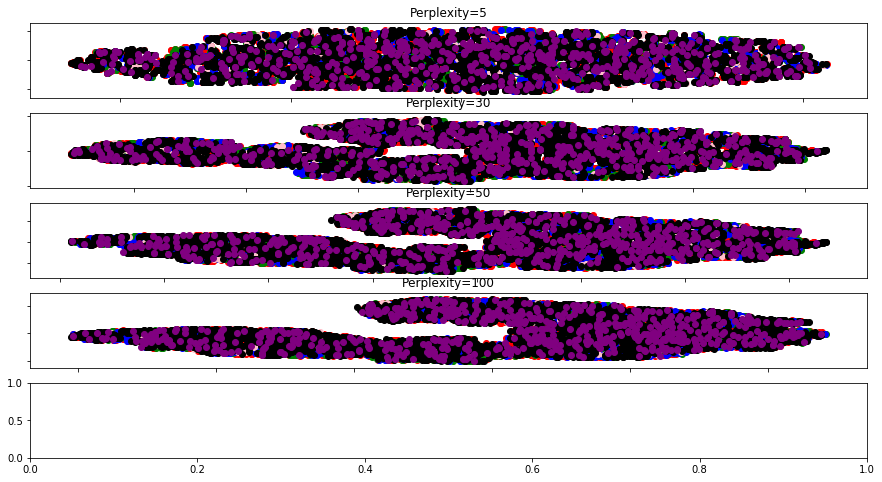

In [10]:
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from time import time

n_components = 2
(fig, subplots) = plt.subplots(5, figsize=(15, 8))
perplexities = [5, 30, 50, 100]
X = x
red = y == 1
green = y == 2
blue = y == 3
pink = y == 4
black = y == 5
purple = y == 6


for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=0, perplexity=perplexity)
    Y = tsne.fit_transform(X)
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[red, 0], Y[red, 1], c="r")
    ax.scatter(Y[green, 0], Y[green, 1], c="g")
    ax.scatter(Y[blue, 0], Y[blue, 1], c="blue")
    ax.scatter(Y[pink, 0], Y[pink, 1], c="pink")
    ax.scatter(Y[black, 0], Y[black, 1], c="black")
    ax.scatter(Y[purple, 0], Y[purple, 1], c="purple")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

In [5]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, x, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

NameError: name 'KerasClassifier' is not defined